# Model Notebook
*Animal Recognition for self-driving cars*

## Import Libraries and Dataset

- Run first cell if you're using this notebook on Google Colab.
- Training and Test datasets loaded from tensorflow:
    * X train shape: (50000, 32, 32, 3)
    * y train shape: (50000, 1)
    * X test shape: (10000, 32, 32, 3)
    * y test shape: (10000, 1)
- Flatten for y train and test so to have 1D array

In [2]:
!git clone https://github.com/Sohib711/Animal-Recognition-App-for-Cars.git

%cd Animal-Recognition-App-for-Cars
%pwd

!pip install visualkeras

fatal: destination path 'Animal-Recognition-App-for-Cars' already exists and is not an empty directory.
/content/Animal-Recognition-App-for-Cars


In [3]:
#say no to warnings!

import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
# Import libraries

import os
import pickle
import numpy as np
import pandas as pd

from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

from src.constants import LABELS, BINARY_LABELS, SEED, BATCH_SIZE, INPUT_SHAPE
from src.utils import is_gpu_active, initialize_report
from src.viz_fx import images_viz, class_distribution, histogram_distributions, viz_images_generator, scatter_plot_metrics,\
                            bar_plot_metric_performances, plot_model_history, plot_misclassified_images, visualize_model
from src.preprocessing import data_gen, binary_y, train_splitting, apply_data_gen
from src.models import build_cnn_model, build_resnet_model, train_model, train_tf_model, add_to_report, \
                        evaluate_model_and_save_results

In [5]:
# Import CIFAR10 dataset

(X_train, y_train), (X_test, y_test) = load_data()

print("="*40)
print("Training information:")
print(f"X train shape: {X_train.shape}")
print(f"y train shape: {y_train.shape}")
print("="*40)
print("Test information:")
print(f"X test shape: {X_test.shape}")
print(f"y test shape: {y_test.shape}")
print("="*40)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Training information:
X train shape: (50000, 32, 32, 3)
y train shape: (50000, 1)
Test information:
X test shape: (10000, 32, 32, 3)
y test shape: (10000, 1)


In [6]:
# Flatten for y train and test so to have 1D array

y_train = y_train.flatten()
y_test = y_test.flatten()

print("="*40)
print(f"y train shape: {y_train.shape}")
print(f"y test shape: {y_test.shape}")
print("="*40)

y train shape: (50000,)
y test shape: (10000,)


## Exploratory Data Analysis (EDA)

1. Visualize training and test contents
2. Check for Max and Min values for X_train and X_test
3. Images visualization for training and test sets
4. Class distribution in training and test
    - 10 classes are perfectly balanced
    - Vehicles and Animals are slightly imbalanced: 40% vs 60%
5. Image histogram distribution with KDE for each channel

In [7]:
# Visualize training and test contents

instance = 0

print("="*80)
print("X train and test:")
print(f"- Type of X train and test: {type(X_train)}, {type(X_test)}")
print(f"- Part of the X train content for element {instance}: \n{X_train[instance,0,0:5,]}")
print(f"- Part of the X test content for element {instance}: \n{X_test[instance,0,0:5,]}")
print("="*80)
print("y train and test:")
print(f"- Type of y train and test: {type(y_train)}, {type(y_test)}")
print(f"- y train has these unique values: \n{np.unique(y_train)}")
print(f"- y test has these unique values: \n{np.unique(y_test)}")
print("="*80)

X train and test:
- Type of X train and test: <class 'numpy.ndarray'>, <class 'numpy.ndarray'>
- Part of the X train content for element 0: 
[[59 62 63]
 [43 46 45]
 [50 48 43]
 [68 54 42]
 [98 73 52]]
- Part of the X test content for element 0: 
[[158 112  49]
 [159 111  47]
 [165 116  51]
 [166 118  53]
 [160 112  46]]
y train and test:
- Type of y train and test: <class 'numpy.ndarray'>, <class 'numpy.ndarray'>
- y train has these unique values: 
[0 1 2 3 4 5 6 7 8 9]
- y test has these unique values: 
[0 1 2 3 4 5 6 7 8 9]


In [8]:
# Max and Min values for X_train and X_test

print("="*50)
print(f"Min and Max values for X train: {np.min(X_train)}, {np.max(X_train)}")
print(f"Min and Max values for X train: {np.min(X_test)}, {np.max(X_test)}")
print("="*50)

Min and Max values for X train: 0, 255
Min and Max values for X train: 0, 255


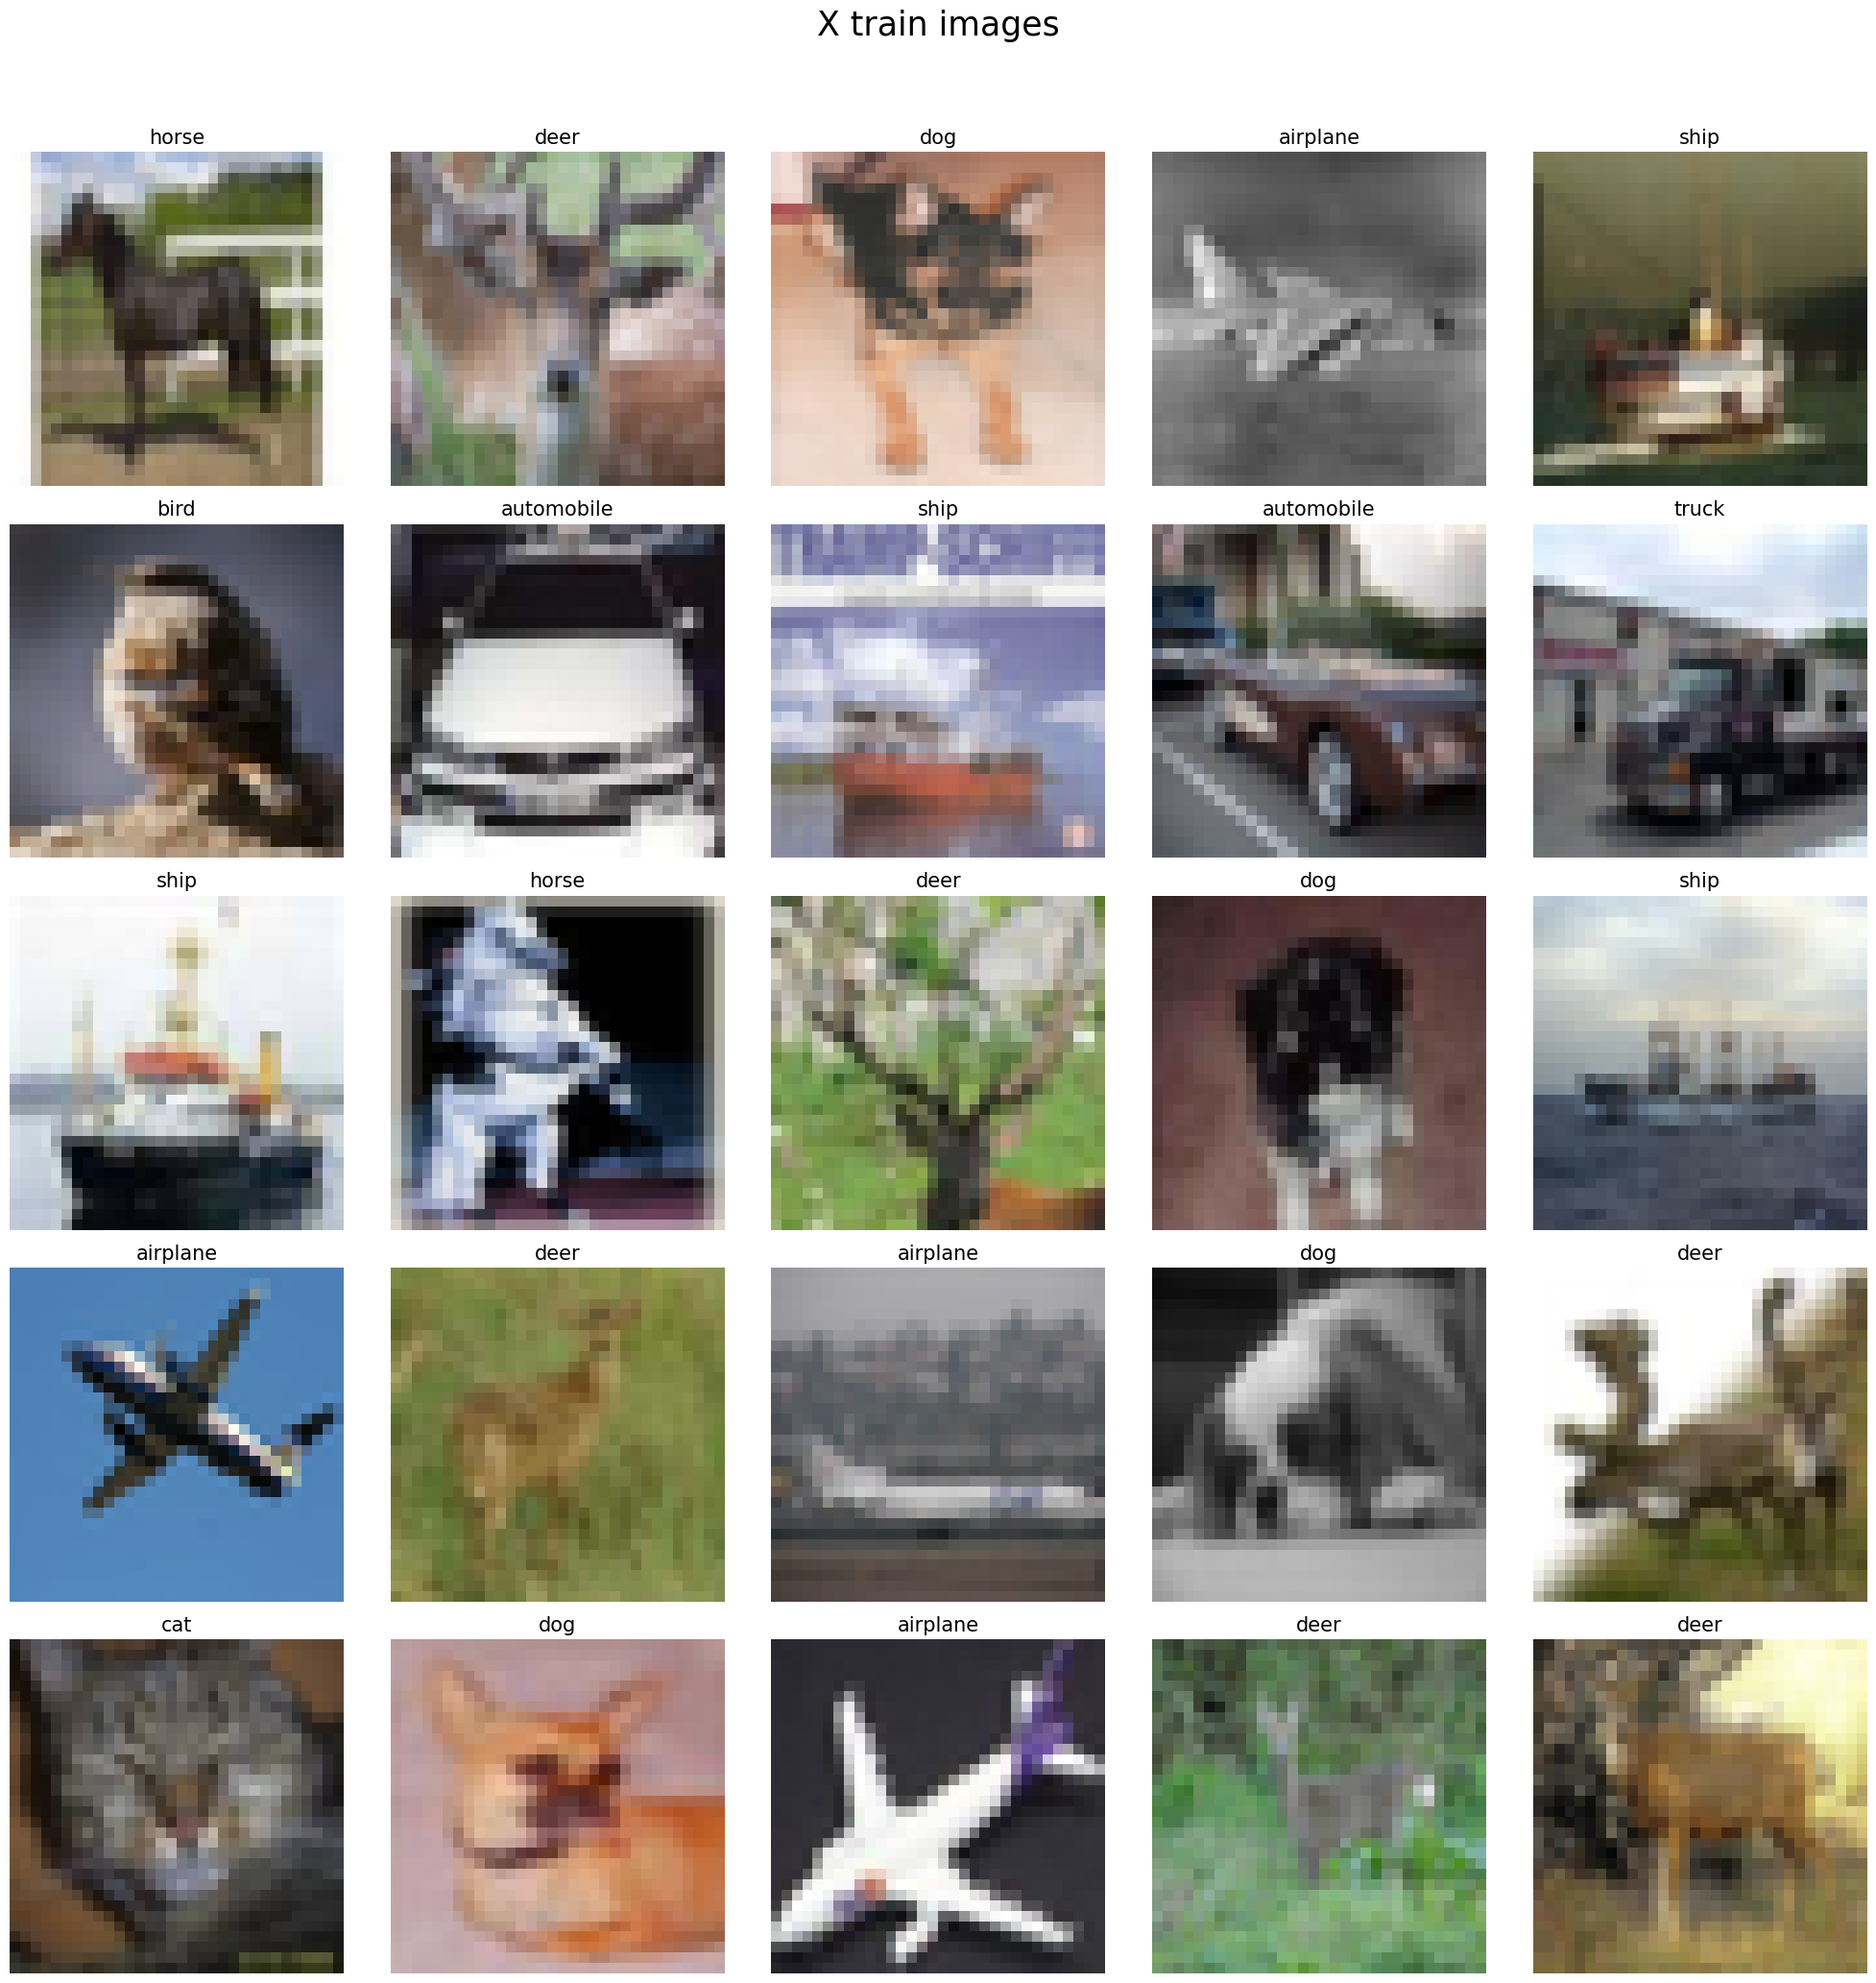

In [9]:
# Images visualization for training

n_rows = 5
n_cols = 5
n_train = len(X_train)

images_viz(n_rows, n_cols, n_train, X_train, y_train, set = 'train')

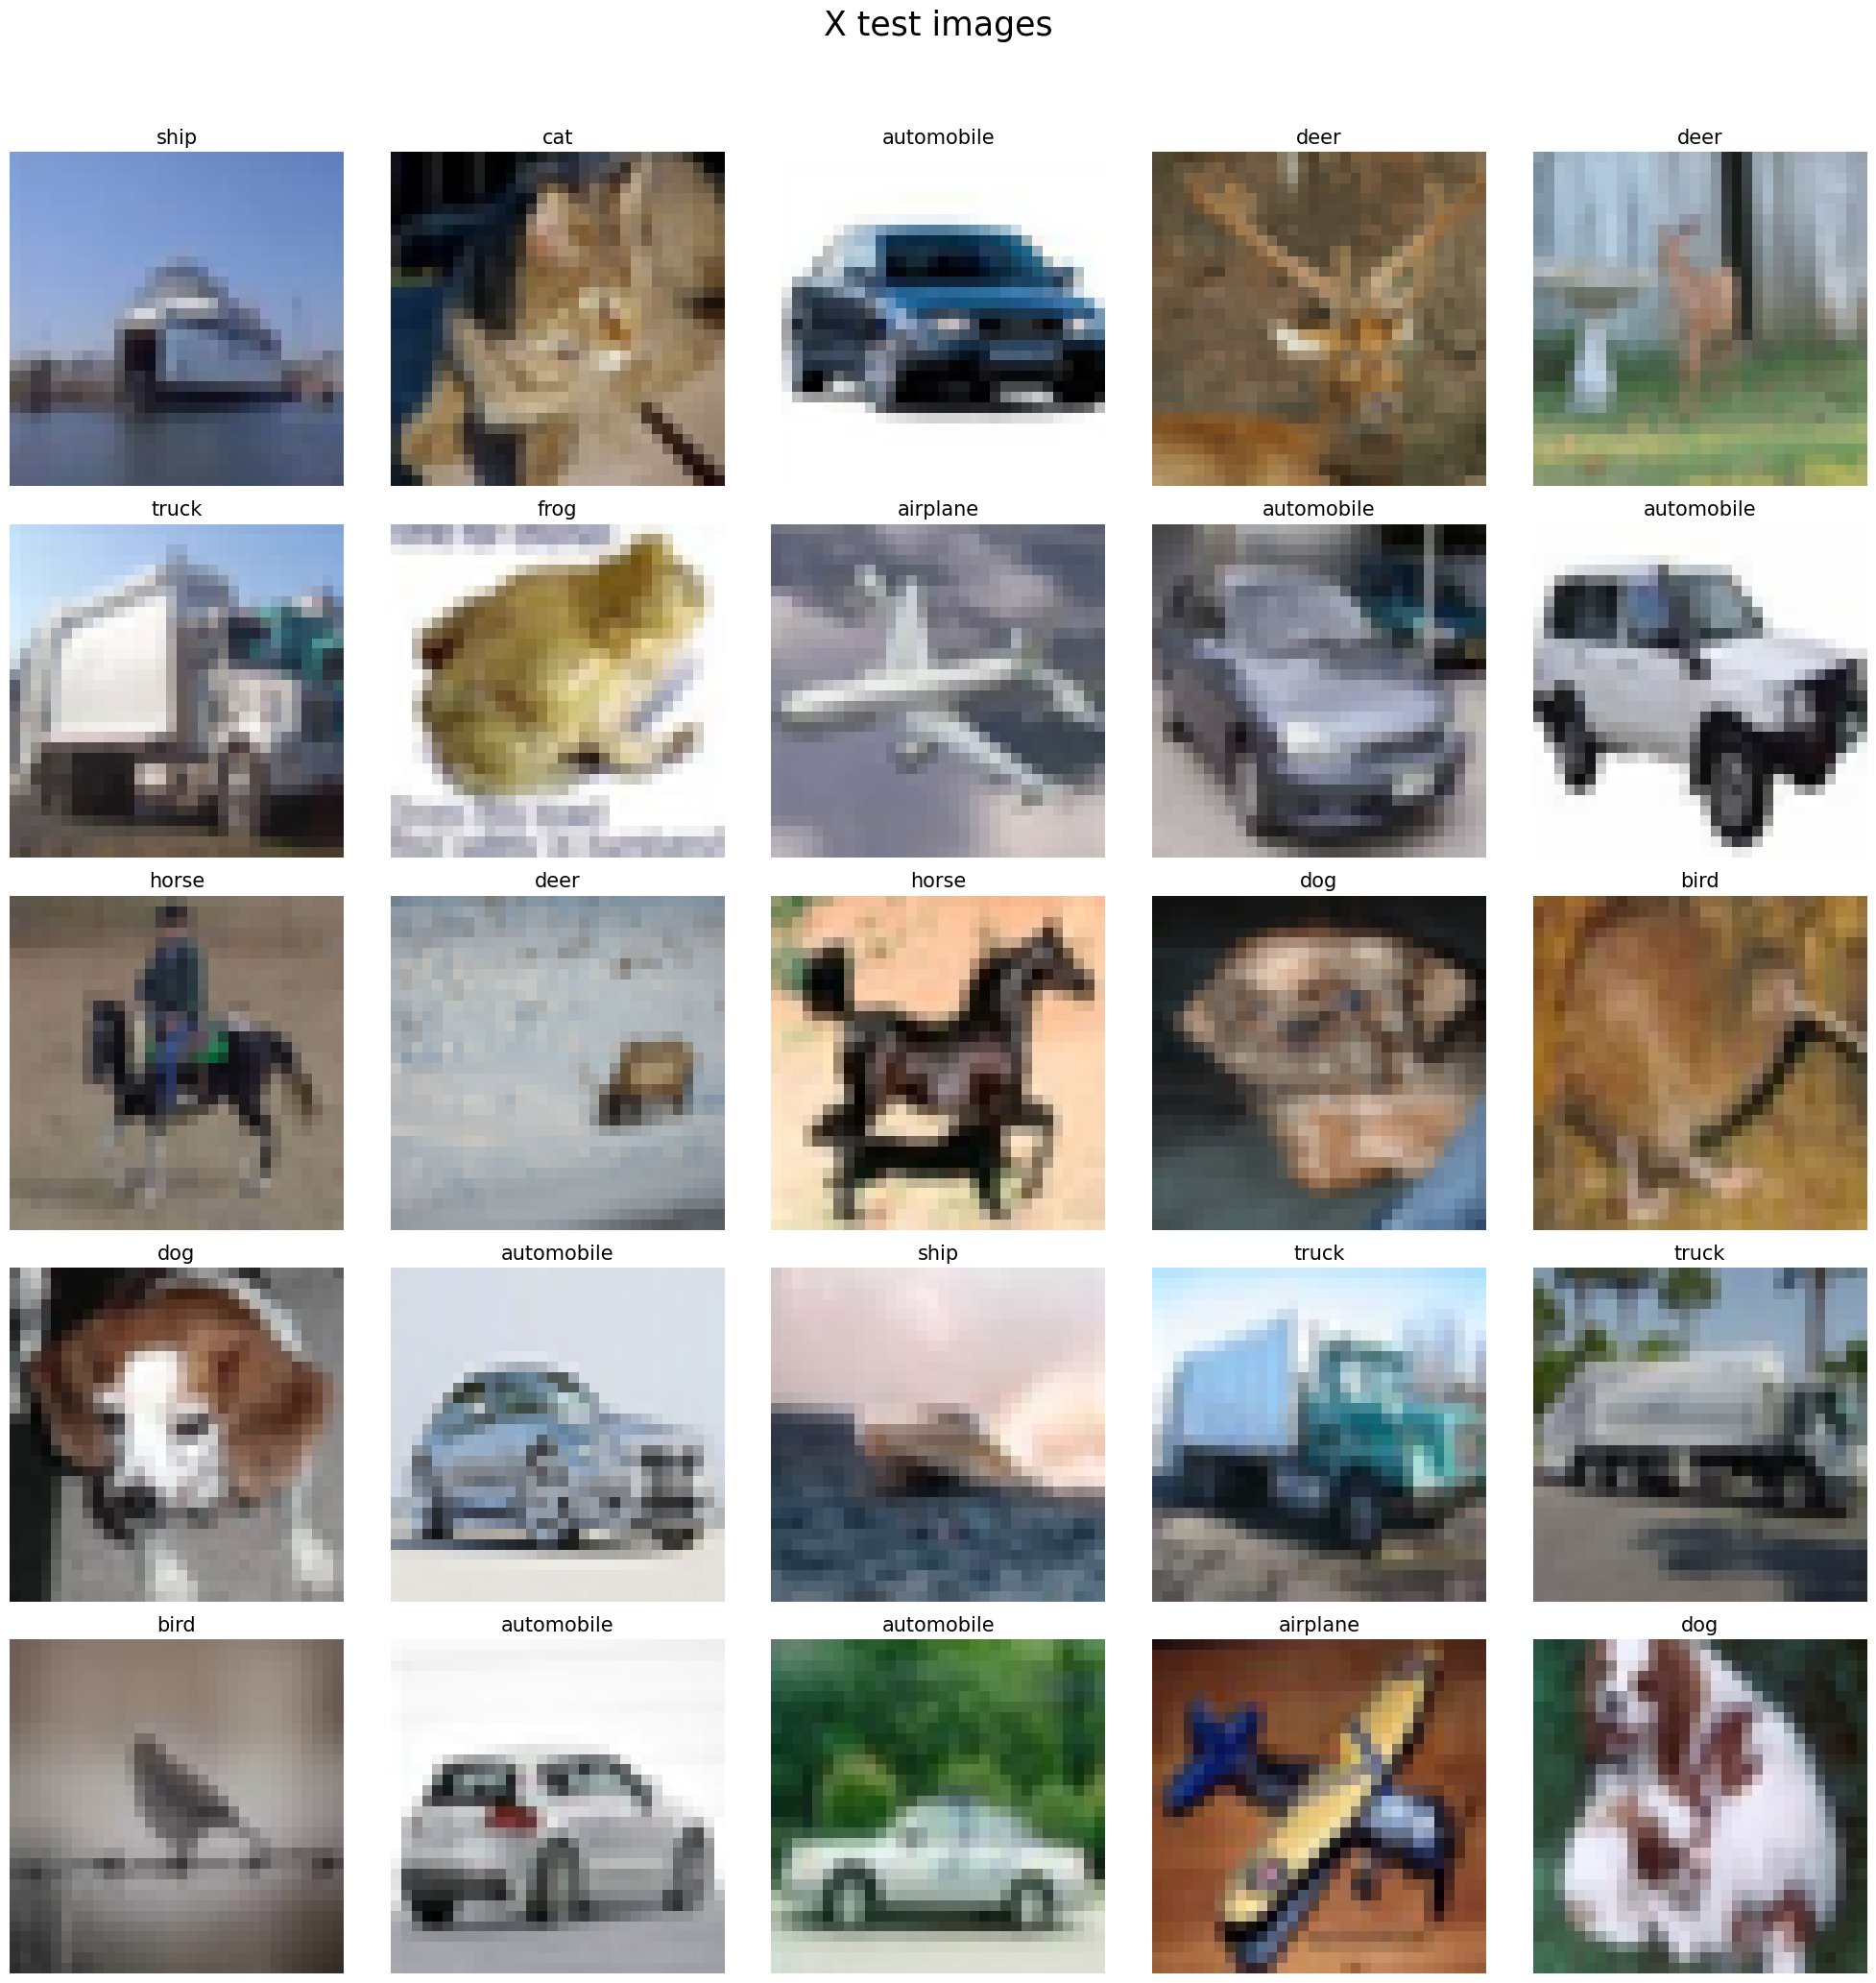

In [10]:
# Images visualization for test

n_rows = 5
n_col = 5
n_test = len(X_test)

images_viz(n_rows, n_cols, n_test, X_test, y_test, set = 'test')

In [11]:
# Class distribution in training and test

class_distribution(y_train, y_test)

In [12]:
# Image histogram distribution with KDE for each channel

instance = 50

histogram_distributions(instance, X_train)

## Preprocessing

1. Define and Visualize Data Augmentation without rescaling, so to have images with 3 channels
2. Transform y labels to binary labels: vehicles (0) and animals (1)
3. Splitting Training set into train and validation
4. Apply Data Augumentation with normalization for training set

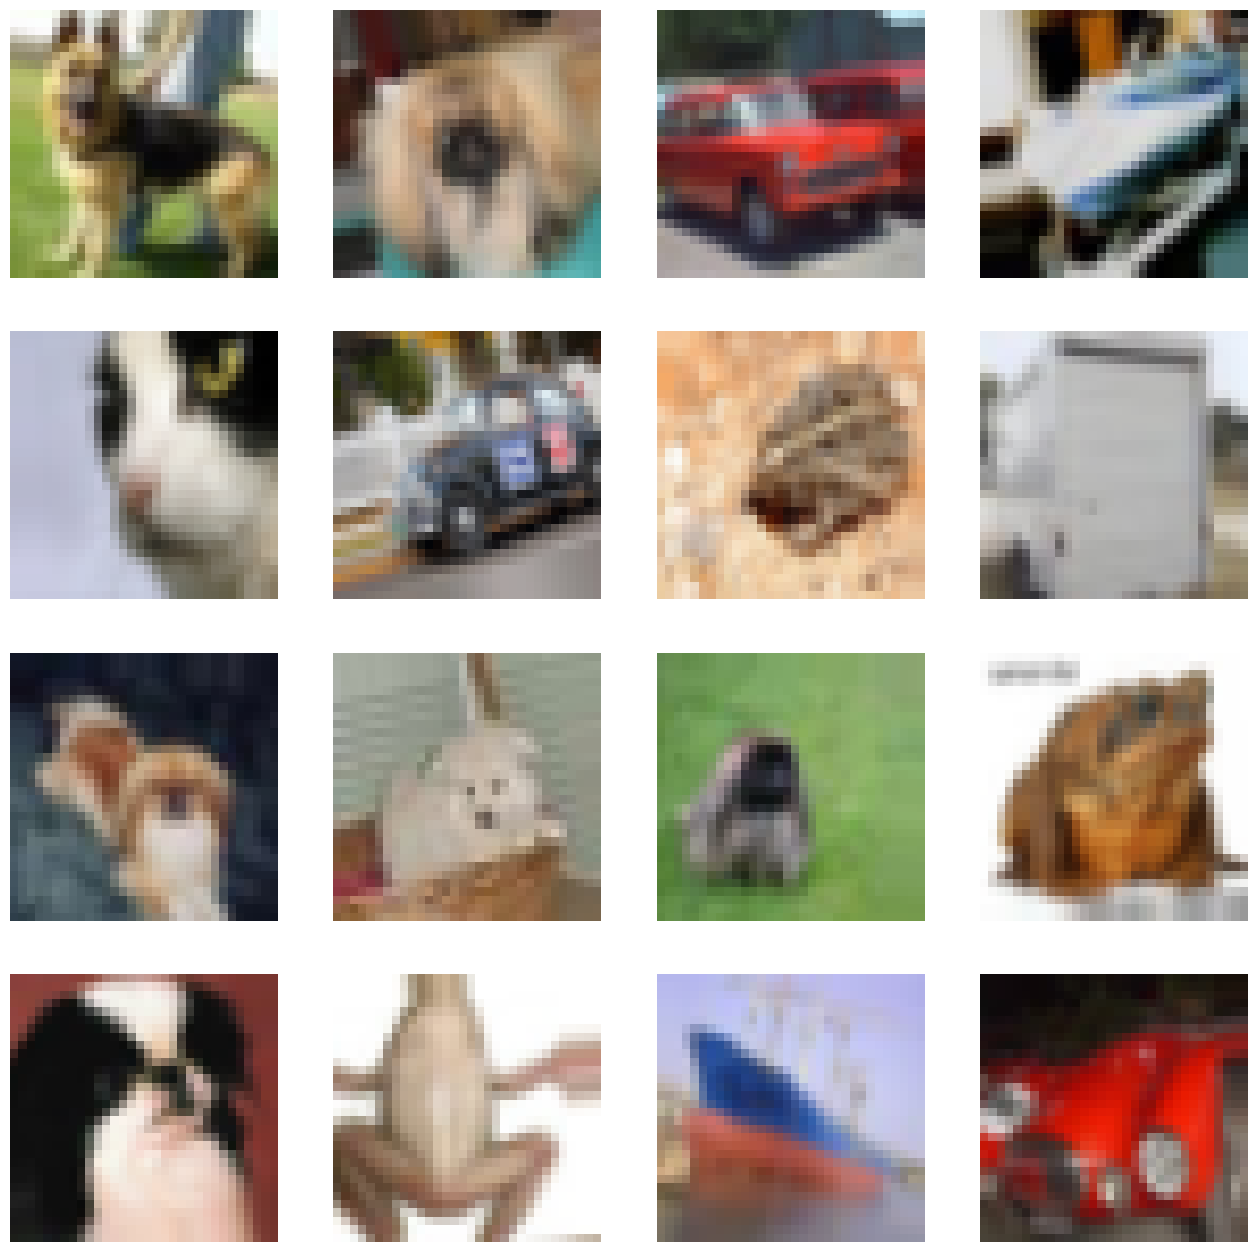

In [13]:
# Define and Visualize Data Augmentation

train_datagen, test_datagen = data_gen(rescale_train=False)

viz_images_generator(train_datagen, X_train)

In [14]:
# Transform y labels to binary labels: vehicles (0) and animals (1)

y_train_binary, y_test_binary = binary_y(y_train, y_test)

First 10 binary labels for training set: 
[1 0 0 1 0 0 1 1 0 1]
['frog' 'truck' 'truck' 'deer' 'automobile' 'automobile' 'bird' 'horse'
 'ship' 'cat']
First 10 binary labels for test set: 
[1 0 0 0 1 1 0 1 1 0]
['cat' 'ship' 'ship' 'airplane' 'frog' 'frog' 'automobile' 'frog' 'cat'
 'automobile']


In [15]:
# Initialize Data Generators with normalization for training set

train_datagen, test_datagen = data_gen(rescale_train=True)

In [16]:
# Splitting Training set into train and validation

X_train_split, X_val, y_train_binary_split, y_val_binary = train_splitting(X_train, y_train_binary, test_size=0.2)

Training information:
X train percentage for training after splitting: 80%
X train shape after splitting: (40000, 32, 32, 3)
y train shape after splitting: (40000,)
Validation information:
X val percentage for validation after splitting: 20%
X val shape after splitting: (10000, 32, 32, 3)
y val shape after splitting: (10000,)


In [17]:
# Apply Data Augumentation

train_generator, val_generator = apply_data_gen(train_datagen, X_train_split, y_train_binary_split,
                                                test_datagen, X_val, y_val_binary)

## Convolutional Neural Network (CNN) from scratch

1. Built 5 different models, details are present in `description` in results report in the `Results` folder.
2. Model evalution was perfomed on the test set offered by CIFAR10
    - Confusion matrix and classification report
3. Models and histories can be saved in the appropriate folders
4. You can find a completely Results discussion in the [ReadMe.md](README.md)

### Building CNN model

In [18]:
# Build and compile a CNN model from scratch

model = build_cnn_model(INPUT_SHAPE, learning_rate=1e-3, lr_dense=1e-3)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_maxpool (MaxPooling2D)   │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_maxpool (MaxPooling2D)   │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_maxpool (MaxPooling2D)   │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 322,081 (1.23 MB)

 Trainable params: 321,185 (1.23 MB)

 Non-trainable params: 896 (3.50 KB)

In [19]:
# Check you are usign GPU

is_gpu_active()

Python Platform: Linux-6.1.123+-x86_64-with-glibc2.35
TensorFlow Version: 2.18.0
Keras Version: 3.8.0
Python Version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]

GPU is NOT AVAILABLE


In [ ]:
# Train CNN model

history = train_model(model, train_generator, val_generator, epochs=30, early_stop_patience=5, class_imb=False)

Epoch 1/30
 221/1250 ━━━━━━━━━━━━━━━━━━━━ 5:23 314ms/step - accuracy: 0.7790 - loss: 0.6521 - precision: 0.8152

In [ ]:
# Saving history file

os.makedirs('History_models', exist_ok=True)

with open('History_models/train_history_3_blocks_32_64_128_1_dense_drop_batch.pkl', 'wb') as file:
  pickle.dump(history.history, file)

In [ ]:
# Saving trained model

os.makedirs("models", exist_ok=True)

model.save("models/model_3_3_blocks_32_64_128_1_dense_drop_batch.keras")

### Model Evaluation

In [ ]:
# Load Model and History from training step

model_name = "model_5_3_blocks_32_64_128_2CNN_2_dense_256_128_drop_batch"
model = load_model("models/"+model_name+".keras")

history_path = "train_history_3_blocks_32_64_128_2CNN_2_dense_256_128_drop_batch.pkl"
with open("History_models/"+history_path, "rb") as file:
    history = pickle.load(file)

In [ ]:
# Function to visualize model Keras 3D

visualize_model(model, to_file="model_visualization.png", font_path="/Library/Fonts/Supplemental/arial.ttf")

In [ ]:
# Saving plot model informaiton

plot_model(model, to_file='images/model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Scatter plots for each metric using an interactive view with Plotly

scatter_plot_metrics(history_path)

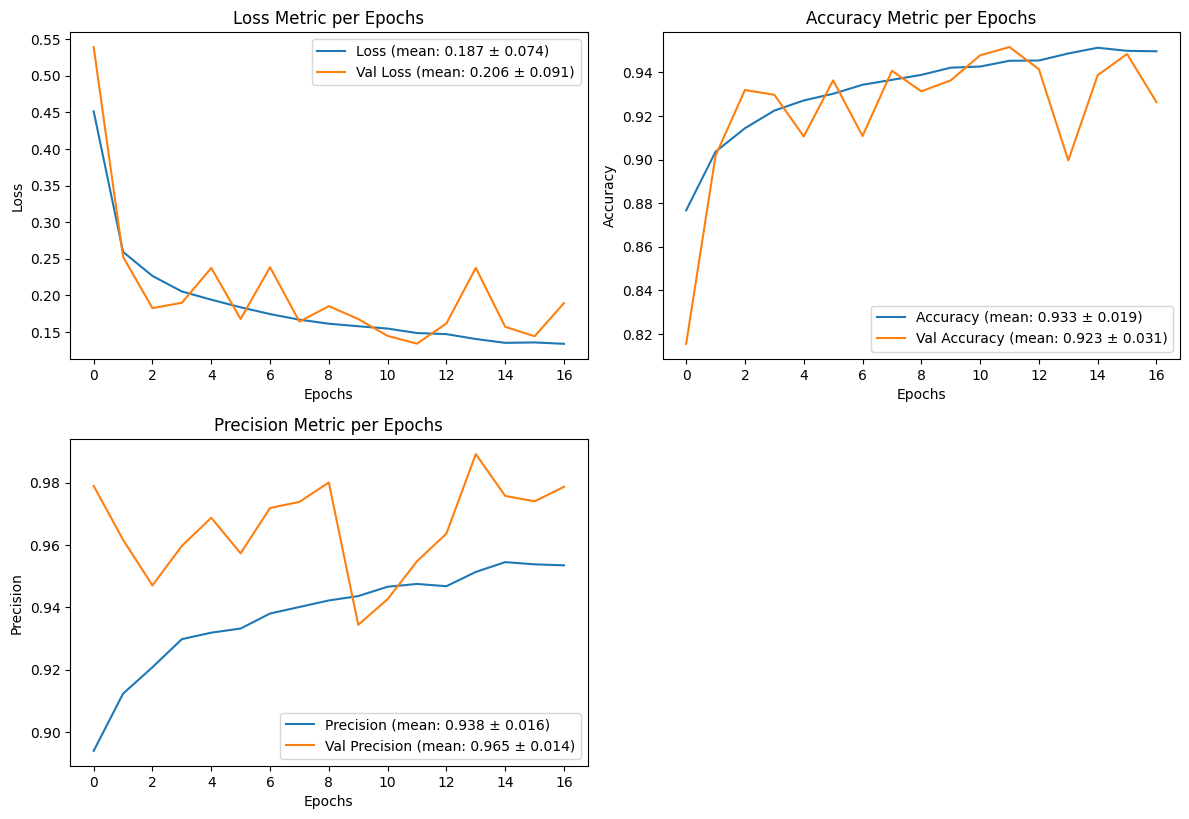

In [ ]:
# Plot model history with matplotlib

fig = plot_model_history(history)
fig.show()

In [ ]:
# Update report results for each CNN

csv_file_path = "Results/report_results.csv"

df_report = initialize_report(csv_file_path)


name_for_model = model_name.split("_")[0] + " " + model_name.split("_")[1]
description = "Model with 3 blocks (2 conv 2 batch 1 max 1 drop per each), global_avg_pool, 2 dense (256, 128, lr 1e-3), dropout, output sigmoid. Adma lr 1e-3"

add_to_report(name_for_model, history, description, df_report, csv_file_path)

In [ ]:
# Review report with models' performances (training and validation)

csv_file_path = "Results/report_results.csv"

report = pd.read_csv(csv_file_path)
report

,Model,accuracy Mean,accuracy Std,loss Mean,loss Std,precision Mean,precision Std,val_accuracy Mean,val_accuracy Std,val_loss Mean,val_loss Std,val_precision Mean,val_precision Std,Description
0,model 1,0.911736,0.014503,0.237132,0.047861,0.920504,0.011382,0.910500,0.024522,0.239250,0.066354,0.932471,0.045251,Model with 3 blocks (1 conv 1 batch 1 max 1 dr...
1,model 2,0.931964,0.018880,0.188406,0.060734,0.938294,0.015730,0.925256,0.026339,0.200481,0.067285,0.960465,0.026318,Model with 3 blocks (2 conv 2 batch 1 max 1 dr...
2,model 3,0.918339,0.017914,0.242586,0.051150,0.919730,0.012005,0.911509,0.061845,0.258746,0.164165,0.947440,0.028342,Model with 3 blocks (2 conv 2 batch 1 max 1 dr...
3,model 4,0.931617,0.022058,0.183670,0.053181,0.938079,0.018143,0.941470,0.012428,0.164386,0.031959,0.949744,0.018258,Model with 3 blocks (2 conv 2 batch 1 max 1 dr...
4,model 5,0.932882,0.019105,0.186855,0.074175,0.937646,0.015845,0.923453,0.031047,0.205539,0.090589,0.965465,0.014345,Model with 3 blocks (2 conv 2 batch 1 max 1 dr...


In [ ]:
# Bar plot to compare models performances for each metric

fig = bar_plot_metric_performances(report)
fig.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9486 - loss: 0.1358 - precision: 0.9513
Test Loss: 0.131
Test Accuracy: 95.000%
Test Precision: 95.305%
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


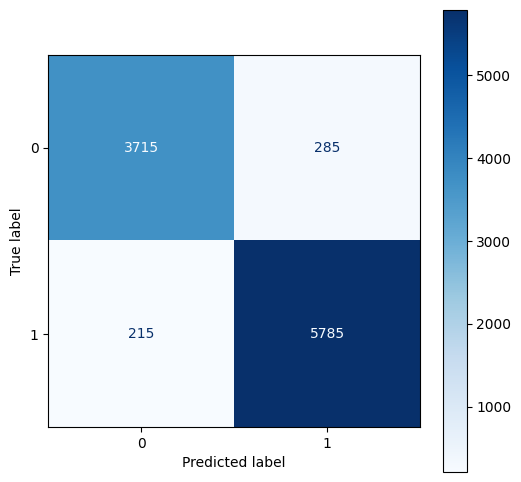

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      4000
           1       0.95      0.96      0.96      6000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [ ]:
# Model evaluation with Test Loss, Accuracy, Precision, Confusion Matrix and Classification Report
# Results are saved in Results folder

model_name='model 4'
evaluate_model_and_save_results(model,model_name, X_test, y_test_binary)

In [ ]:
# Import and look at the test results for each method

results_test = pd.read_csv("Results/test_metrics.csv")
results_test

,Model,Test Loss,Test Accuracy,Test Precision
0,model 1,0.156,94.19,95.181
1,model 2,0.123,95.37,95.542
2,model 3,0.146,95.37,96.964
3,model 4,0.121,95.32,96.628
4,model 4,0.131,95.00,95.305


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


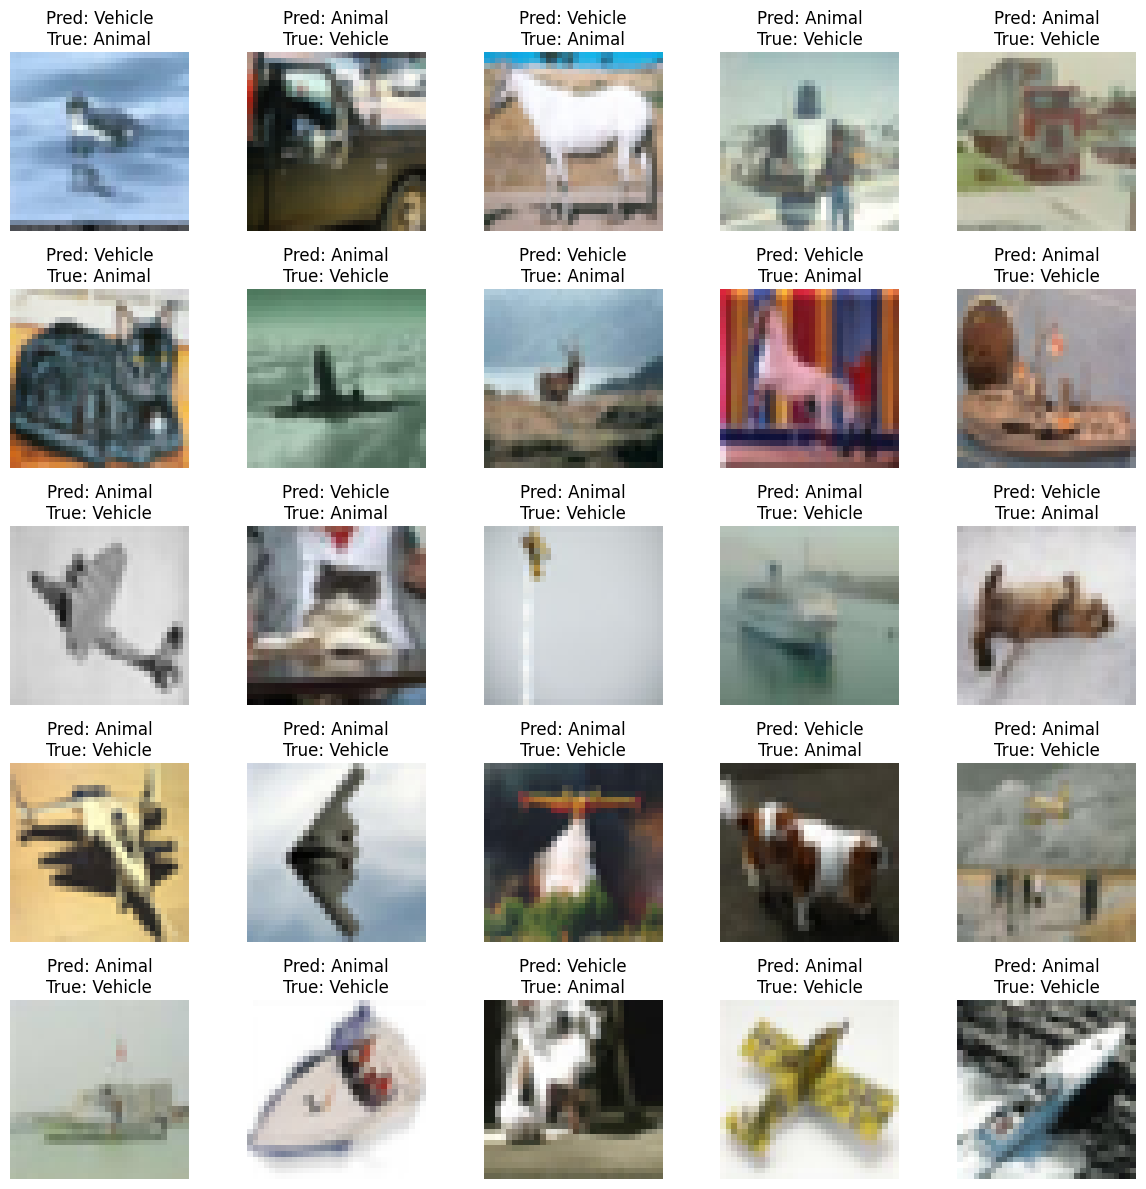

In [ ]:
# Visualize images wrongly classified from test set

plot_misclassified_images(model, X_test, y_test_binary, ['Vehicle', 'Animal'], num_images=25)

## CNN Transfer Learning model

1. Built 3 different models, details are present in `description` in results report in the `Results` folder.
2. Model evalution was perfomed on the test set offered by CIFAR10
    - Confusion matrix and classification report
3. Models and histories can be saved in the appropriate folders
4. You can find a completely Results discussion in the [ReadMe.md](README.md)

### Build TF model

In [ ]:
# Check for gpu

is_gpu_active()

Python Platform: macOS-12.5-arm64-arm-64bit
TensorFlow Version: 2.17.0
Keras Version: 3.5.0
Python Version: 3.11.9 (main, Jul 16 2024, 11:07:54) [Clang 14.0.0 (clang-1400.0.29.202)]

GPU is NOT AVAILABLE


In [ ]:
# Train transfer learning model

print("\nTraining ResNet50V2 model:")
model = build_resnet_model()

#print("Training EfficientNetB0 model:")
#model = build_efficientnet_model()

#print("\nTraining InceptionV3 model:")
#model = build_inception_model()

history = train_tf_model(model, train_generator, val_generator, epochs=30, class_imb=False)

In [ ]:
# Saving history file

os.makedirs('History_models', exist_ok=True)

with open('History_models/tf_history_model_1_.pkl', 'wb') as file:
  pickle.dump(history.history, file)

In [ ]:
# Saving trained model

os.makedirs("models", exist_ok=True)

model.save("models/tf_model_1_.keras")

### Model Evaluation

In [ ]:
# Load TF Model and History from training step

model_name = "tf_model_3"
model = load_model("models/"+model_name+".keras")

history_path = "tf_history_model_3.pkl"
with open("History_models/"+history_path, "rb") as file:
    history = pickle.load(file)

In [ ]:
# Scatter plots for each metric using an interactive view with Plotly

scatter_plot_metrics(history_path)

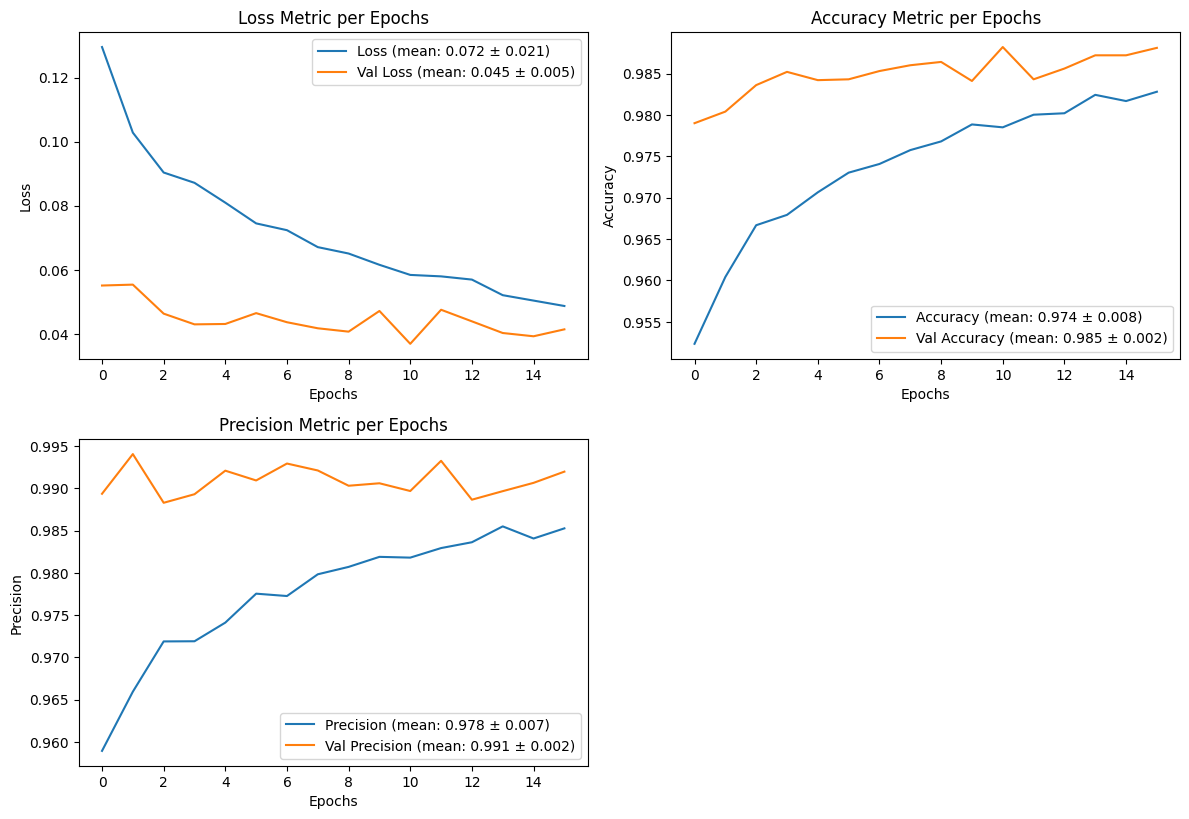

In [ ]:
# Plot model history with matplotlib

fig = plot_model_history(history)
fig.show()

In [ ]:
# Update report results for each CNN

csv_file_path = "Results/report_tf_results.csv"

df_report = initialize_report(csv_file_path)

name_for_model = model_name.split("_")[1] + " " + model_name.split("_")[2]
description = "ResNet50V2, base model freezed, upsampling, GlobalAveragePooling2D (BatchNorm and Dropout 0.1), 2 Dense (1028, 512), Dropout 0.1, Adam 1e-3"

add_to_report(name_for_model, history, description, df_report, csv_file_path)

In [ ]:
# Review report with models' performances (training and validation)

csv_file_path = "Results/report_tf_results.csv"
report = pd.read_csv(csv_file_path)
report

,Model,accuracy Mean,accuracy Std,loss Mean,loss Std,precision Mean,precision Std,val_accuracy Mean,val_accuracy Std,val_loss Mean,val_loss Std,val_precision Mean,val_precision Std,Description,learning_rate Mean,learning_rate Std
0,model 1,0.982295,0.008606,0.047785,0.022933,0.985030,0.007281,0.984338,0.002486,0.050633,0.004679,0.989692,0.001907,"ResNet50V2, base model freezed, upsampling, Gl...",0.000486,0.000449
1,model 2,0.982943,0.008559,0.046214,0.023251,0.985531,0.007123,0.984428,0.001294,0.051987,0.005160,0.988536,0.002532,"ResNet50V2, base model freezed, upsampling, Gl...",0.000686,0.000421
2,model 3,0.973884,0.008262,0.072273,0.021083,0.977703,0.007239,0.984944,0.002430,0.044514,0.004964,0.990860,0.001656,"ResNet50V2, base model freezed, upsampling, Gl...",0.001000,0.000000


In [ ]:
# Bar plot to compare models performances for each metric

fig = bar_plot_metric_performances(report)
fig.show()

I0000 00:00:1727169044.506315 99322532 service.cc:146] XLA service 0x31c719640 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727169044.506846 99322532 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1727169045.572047 99322532 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.9831 - loss: 0.0465 - precision: 0.9836
Test Loss: 0.043
Test Accuracy: 98.400%
Test Precision: 98.634%
313/313 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step


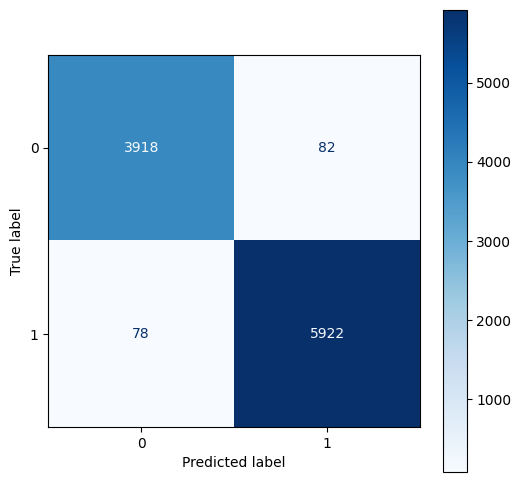

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4000
           1       0.99      0.99      0.99      6000

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [ ]:
# Model evaluation with Test Loss, Accuracy, Precision, Confusion Matrix and Classification Report
# Results are saved in Results folder

model_name='model 3'
evaluate_model_and_save_results(model,model_name, X_test, y_test_binary, "Results/test_tf_metrics.csv")

In [ ]:
# Import and look at the test results for each method

results_test = pd.read_csv("Results/test_tf_metrics.csv")
results_test

,Model,Test Loss,Test Accuracy,Test Precision
0,model 1,0.042,98.70,99.113
1,model 2,0.052,98.45,99.192
2,model 3,0.043,98.40,98.634


313/313 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step


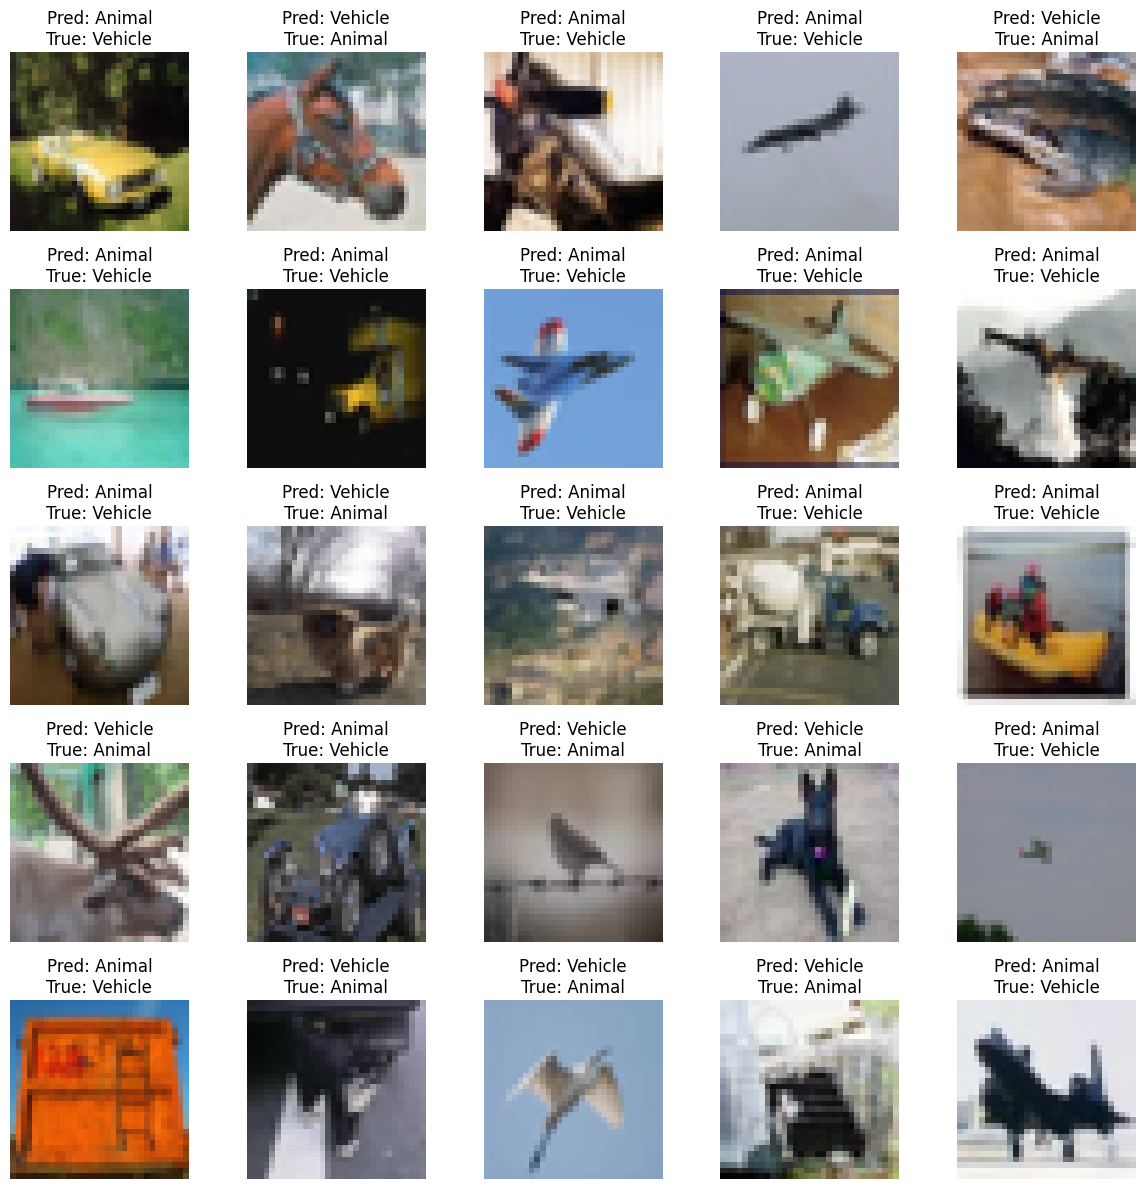

In [ ]:
# Visualize images wrongly classified from test set

plot_misclassified_images(model, X_test, y_test_binary, ['Vehicle', 'Animal'], num_images=25)